In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import train_test_split

%matplotlib inline 

In [22]:
mag7_tickers = ['AAPL', 'AMZN', 'META', 'GOOGL', 'TSLA', 'NVDA', 'MSFT']

mag7_data = {}

#Collect data for all tickers above

for ticker in mag7_tickers:
    
    ticker_data = yf.Ticker(ticker).history(period = '10y')[['Close', 'Volume']]
    
    ticker_data['Returns'] = np.log(ticker_data['Close'] / ticker_data['Close'].shift())
    
    mag7_data[ticker] = ticker_data
    
#Collect just returns data for all tickers above    
    
mag7_returns = {}

for ticker in mag7_data:
    
    mag7_returns[ticker] = mag7_data[ticker]['Returns']
    
mag7_returns = pd.concat(mag7_returns, axis = 1).dropna()

#Collect the risk-free rate and market returns

rf_rate = yf.Ticker('^TNX').history(period = '10y')['Close'] / 100

SPX = pd.DataFrame(yf.Ticker('^SPX').history(period = '10y')['Close'])

SPX['Returns'] = np.log(SPX / SPX.shift())

In [3]:
#Split the returns data into training and testing sets

mag7_train = train_test_split(mag7_returns, train_size = 0.8, shuffle = False)[0]

rf_rate_train = train_test_split(rf_rate, train_size = 0.8, shuffle = False)[0]

#Calculate the annual returns and variance covariance matrices

mag7_train_returns = mag7_train.mean() * 252

mag7_train_cov = mag7_train.cov() * 252

rf_rate_train = rf_rate_train.mean()

weights = np.random.rand(len(mag7_train.columns))

weights = weights / np.sum(weights)

#Define a function to maximize Sharpe Ratio

def sharpe_ratio(weight_matrix):
    
    weights = np.array(weight_matrix / np.sum(weight_matrix))
    
    port_returns = np.dot(mag7_train_returns, weights)
    
    port_std = np.sqrt(np.dot(weights.T, np.dot(mag7_train_cov, weights)))
    
    #Return the negative of Sharpe Ratio to minimize which is equivalent to maximizing the positive Sharpe Ratio value 
    
    return - (port_returns - rf_rate_train) / port_std

from scipy import optimize

#Creating weight bounds for each Ticker

bounds = [tuple([0, 1]) for x in range(len(mag7_train.columns))]

equal_const = optimize.LinearConstraint(np.ones(len(mag7_train.columns)), 1, 1)

result = optimize.minimize(sharpe_ratio, weights, bounds = bounds, constraints = equal_const)

result = result.x 

x = lambda array: [str(str(round(el, 2) * 100) + '%') for el in array]

np.set_printoptions(precision = 2, suppress = True)

print('The optimal portfolio weights are:\n', x(result), '\n')

The optimal portfolio weights are:
 ['26.0%', '22.0%', '0.0%', '0.0%', '7.000000000000001%', '34.0%', '10.0%'] 



In [4]:
mag7_test = train_test_split(mag7_returns, test_size = 0.2, shuffle = False)[1]

rf_rate_test = train_test_split(rf_rate, test_size = 0.2, shuffle = False)[1]

mag7_test_returns = mag7_test.mean() * 252

mag7_test_cov = mag7_test.cov() * 252

rf_rate_test = train_test_split(rf_rate, test_size = 0.2, shuffle = False)[1]

rf_rate_test = rf_rate_test.mean()

port_returns_test = np.dot(result, mag7_test_returns)

port_std_test = np.dot(result.T, np.dot(mag7_test_cov, result))

sharpe_ratio_test = (port_returns_test - rf_rate_test) / port_std_test

print('The optimal sharpe ratio for the Testing Portfolio is', np.round(sharpe_ratio_test, 5))

The optimal sharpe ratio for the Testing Portfolio is 4.26191


In [89]:
equal_weights = np.array([1/len(mag7_test.columns) for x in range(len(mag7_test.columns))])

equal_port_returns_test = np.dot(equal_weights, mag7_test_returns)

equal_port_std_test = np.dot(equal_weights.T, np.dot(mag7_test_cov, equal_weights))

In [90]:
mag7_test_cum_ret = mag7_test.iloc[:-1].cumsum()

port_test_cum_ret = pd.DataFrame(np.dot(mag7_test_cum_ret, result), index = mag7_test_cum_ret.index)

equal_port_test_cum_ret = pd.DataFrame(np.dot(mag7_test_cum_ret, equal_weights), index = mag7_test_cum_ret.index)

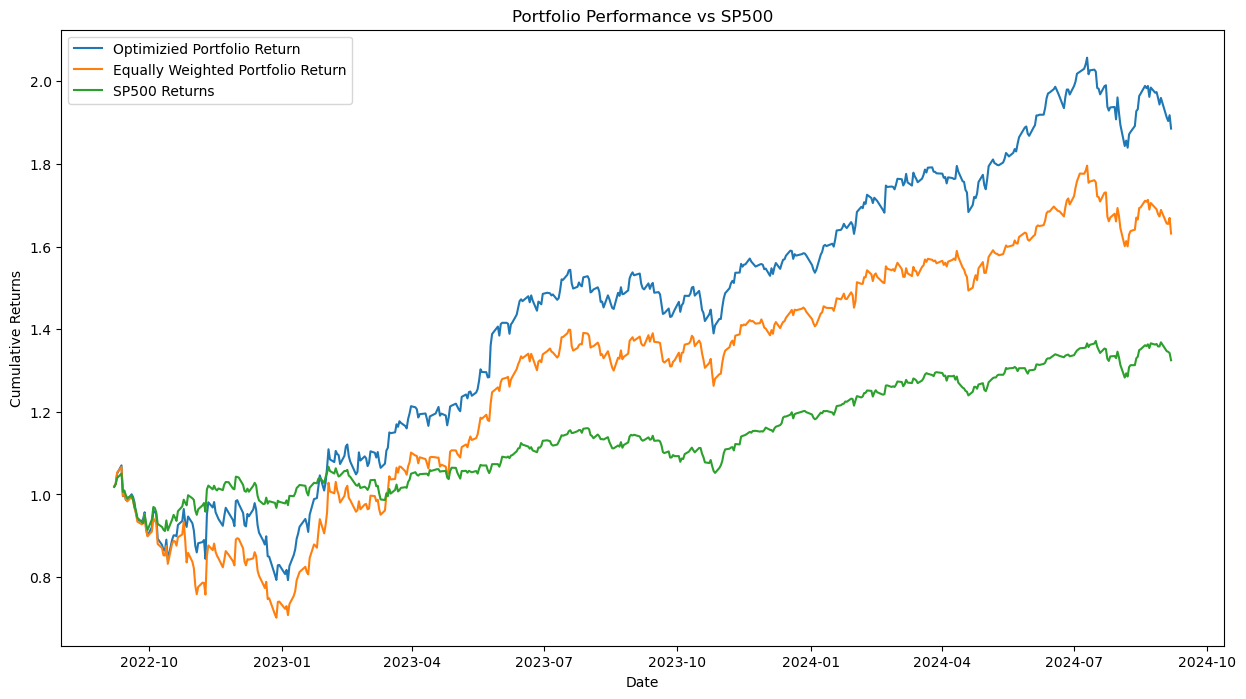

In [94]:
fig = plt.figure(figsize = (15, 8))

plt.plot(port_test_cum_ret + 1, label = 'Optimizied Portfolio Return')

plt.plot(equal_port_test_cum_ret + 1, label = 'Equally Weighted Portfolio Return')

plt.plot(SPX.loc[mag7_test_cum_ret.index]['Returns'].cumsum() + 1, label = 'SP500 Returns')

plt.legend(loc = 'upper left')

plt.title('Portfolio Performance vs SP500')

plt.xlabel('Date')

plt.ylabel('Cumulative Returns')

plt.show()